# Image Classification using AWS Sagemaker

This notebook lists all the steps that you need to complete the complete this project. You will need to complete all the TODOs in this notebook as well as in the README and the two python scripts included with the starter code.


This notebook helps us work with Sagemaker by finding the best hyperparameters, running training jobs, and deploying the model for use. It also includes tools to track and debug the training process. Reports will be created to show how the training went, ensuring the model performs well.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of these the TODO's and use more than one TODO code cell to do all your tasks.

In [1]:
!pip install smdebug
!pip install bokeh==2.4.3

In [2]:
import os
import boto3
import requests
import sagemaker
from PIL import Image
from io import BytesIO
from sagemaker.pytorch import PyTorch, PyTorchModel
from sagemaker.debugger import (
    Rule,
    ProfilerRule, 
    ProfilerConfig, 
    FrameworkProfile,
    DebuggerHookConfig,
    rule_configs,
)

from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)

from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys
from smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml
[2024-08-15 07:05:24.303 default:427 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None


In [3]:
sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()
region = sagemaker_session.boto_session.region_name
role = sagemaker.get_execution_role()

## Dataset
The Dog Breed Classification dataset contains images from 133 dog breeds, divided into training, testing, and validation sets. It’s commonly used in machine learning to train models for accurately identifying dog breeds based on images.

In [19]:
# Fetch data
# IMPORTANT! Run only the first time! 
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip --no-check-certificate
!unzip -q dogImages.zip

--2024-08-13 14:16:31--  https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.121.0, 52.219.192.48, 52.219.121.64, ...
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.121.0|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 1132023110 (1.1G) [application/zip]
Saving to: ‘dogImages.zip’

dogImages.zip       100%[===================>]   1.05G  27.2MB/s    in 35s     

2024-08-13 14:17:07 (30.7 MB/s) - ‘dogImages.zip’ saved [1132023110/1132023110]



In [17]:
# Upload to S3
# IMPORTANT! Run only the first time!
sagemaker_session.upload_data(path='dogImages', bucket=bucket, key_prefix='dogImages')

's3://sagemaker-us-east-1-352619666520/dogImages'

In [6]:
data = "s3://sagemaker-us-east-1-352619666520/dogImages"

In [9]:
os.environ['SM_CHANNEL_TRAINING']= data
os.environ['SM_MODEL_DIR']=f'{data}/model/'
os.environ['SM_OUTPUT_DATA_DIR']=f'{data}/output/'

!echo $SM_CHANNEL_TRAINING
!echo $SM_MODEL_DIR
!echo $SM_OUTPUT_DATA_DIR

s3://sagemaker-us-east-1-352619666520/dogImages
s3://sagemaker-us-east-1-352619666520/dogImages/model/
s3://sagemaker-us-east-1-352619666520/dogImages/output/


## Hyperparameter Tuning
I set 'batch_size', 'learning_rate', 'epochs' and 'early-stopping-rounds' as hyperparameters because they directly influence the training efficiency and performance of the model.
The batch size controls how many samples are processed before updating the model, affecting memory usage and training stability. 
The learning rate determines the step size in updating model weights, influencing the convergence speed and the model's ability to find a good solution.
The epochs paramters is used to have an efficent training time.
The early stopping rounds is used to prevent overfitting during model training by stopping the training process if the model's performance on a validation set doesn't improve after a certain number of rounds (or iterations).

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [10]:
hyperparameter_ranges = {
    "learning-rate": ContinuousParameter(0.001, 0.1),
    "batch-size": CategoricalParameter([16, 64]),
    "epochs": IntegerParameter(5, 10),
    "early-stopping-rounds": CategoricalParameter([10, 12, 15, 17, 20])
}

objective_metric_name = "Average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "Average test loss", "Regex": "Test Loss: ([+-]?[0-9\\.]+)"}]

In [11]:
estimator = PyTorch(
    entry_point="hpo.py",
    role=role,
    py_version='py36',
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.g4dn.xlarge"
)

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=10,
    max_parallel_jobs=2,
    objective_type=objective_type,
)

In [12]:
tuner.fit({"training": data}, wait=True)

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


..................................................................................................................................................................................................................................................................................................................................................!


In [16]:
best_estimator = tuner.best_estimator()

best_hyperparameters = {
    "learning-rate": best_estimator.hyperparameters()["learning-rate"],
    "batch-size": int(best_estimator.hyperparameters()["batch-size"].replace('"', "")),
    "epochs": best_estimator.hyperparameters()["epochs"],
    "early-stopping-rounds": int(best_estimator.hyperparameters()['early-stopping-rounds'].replace('"', ''))
}

best_hyperparameters


2024-08-15 07:36:37 Starting - Found matching resource for reuse
2024-08-15 07:36:37 Downloading - Downloading the training image
2024-08-15 07:36:37 Training - Training image download completed. Training in progress.
2024-08-15 07:36:37 Uploading - Uploading generated training model
2024-08-15 07:36:37 Completed - Resource released due to keep alive period expiry


{'learning-rate': '0.0020378515069008995',
 'batch-size': 64,
 'epochs': '7',
 'early-stopping-rounds': 10}

## Model Profiling and Debugging
I will use the best hyperparameters from the previous step to train the model.

hyperparameters:

```json
{
    'learning-rate': '0.0020378515069008995',
     'batch-size': 64,
     'epochs': '7',
     'early-stopping-rounds': 10
}
```

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [17]:
rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]

hook_config = DebuggerHookConfig(
    hook_parameters={
        "train.save_interval": "100",
        "eval.save_interval": "10"
    }
)

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, 
    framework_profile_params=FrameworkProfile(num_steps=1)
)

Framework profiling will be deprecated from tensorflow 2.12 and pytorch 2.0 in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [19]:
estimator = PyTorch(
    role=role,
    instance_count=2,
    base_job_name="dog-images-training",
    instance_type="ml.g4dn.xlarge",
    entry_point="train_model.py",
    framework_version="1.8",
    py_version="py36",
    hyperparameters=best_hyperparameters,
    profiler_config=profiler_config,
    debugger_hook_config=hook_config,
    rules=rules,
)

estimator.fit({"training": data}, wait=True)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: dog-images-training-2024-08-15-08-15-18-816


2024-08-15 08:15:19 Starting - Starting the training job...
2024-08-15 08:15:48 Starting - Preparing the instances for trainingVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
ProfilerReport: InProgress
...
2024-08-15 08:16:11 Downloading - Downloading input data......
2024-08-15 08:17:08 Downloading - Downloading the training image.....................
2024-08-15 08:20:50 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2024-08-15 08:20:55,407 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2024-08-15 08:20:55,435 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2024-08-15 08:20:55,439 sagemaker_pytorch_container.training INFO     Invoking user training script.
2024-08-15 08:20:55,734 sagemaker-training-toolkit I

In [20]:
last_successful = estimator.latest_job_debugger_artifacts_path()
trial = create_trial(last_successful)

[2024-08-15 08:49:11.795 default:427 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-352619666520/dog-images-training-2024-08-15-08-15-18-816/debug-output


In [21]:
trial.tensor_names()

[2024-08-15 08:49:27.241 default:427 INFO trial.py:197] Training has ended, will refresh one final time in 1 sec.
[2024-08-15 08:49:28.261 default:427 INFO trial.py:210] Loaded all steps


['CrossEntropyLoss_output_0',
 'gradient/ResNet_fc.0.bias',
 'gradient/ResNet_fc.0.weight',
 'gradient/ResNet_fc.2.bias',
 'gradient/ResNet_fc.2.weight',
 'layer1.0.relu_input_0',
 'layer1.0.relu_input_1',
 'layer1.0.relu_input_2',
 'layer1.1.relu_input_0',
 'layer1.1.relu_input_1',
 'layer1.1.relu_input_2',
 'layer1.2.relu_input_0',
 'layer1.2.relu_input_1',
 'layer1.2.relu_input_2',
 'layer2.0.relu_input_0',
 'layer2.0.relu_input_1',
 'layer2.0.relu_input_2',
 'layer2.1.relu_input_0',
 'layer2.1.relu_input_1',
 'layer2.1.relu_input_2',
 'layer2.2.relu_input_0',
 'layer2.2.relu_input_1',
 'layer2.2.relu_input_2',
 'layer2.3.relu_input_0',
 'layer2.3.relu_input_1',
 'layer2.3.relu_input_2',
 'layer3.0.relu_input_0',
 'layer3.0.relu_input_1',
 'layer3.0.relu_input_2',
 'layer3.1.relu_input_0',
 'layer3.1.relu_input_1',
 'layer3.1.relu_input_2',
 'layer3.2.relu_input_0',
 'layer3.2.relu_input_1',
 'layer3.2.relu_input_2',
 'layer3.3.relu_input_0',
 'layer3.3.relu_input_1',
 'layer3.3.rel

In [22]:
len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.TRAIN))

9

In [23]:
len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.EVAL))

2

In [24]:
training_job_name = estimator.latest_training_job.name
training_job_name

'dog-images-training-2024-08-15-08-15-18-816'

In [178]:
training_job = TrainingJob(training_job_name, region)
training_job.wait_for_sys_profiling_data_to_be_available()

ProfilerConfig:{'S3OutputPath': 's3://sagemaker-us-east-1-352619666520/', 'ProfilingIntervalInMilliseconds': 500, 'ProfilingParameters': {'DataloaderProfilingConfig': '{"StartStep": 0, "NumSteps": 1, "MetricsRegex": ".*", }', 'DetailedProfilingConfig': '{"StartStep": 0, "NumSteps": 1, }', 'FileOpenFailThreshold': '50', 'HorovodProfilingConfig': '{"StartStep": 0, "NumSteps": 1, }', 'LocalPath': '/opt/ml/output/profiler', 'PythonProfilingConfig': '{"StartStep": 0, "NumSteps": 1, "ProfilerName": "cprofile", "cProfileTimer": "total_time", }', 'RotateFileCloseIntervalInSeconds': '60', 'RotateMaxFileSizeInBytes': '10485760', 'SMDataParallelProfilingConfig': '{"StartStep": 0, "NumSteps": 1, }'}, 'DisableProfiler': False}
s3 path:s3://sagemaker-us-east-1-352619666520/dog-images-training-2024-08-15-08-15-18-816/profiler-output


Profiler data from system is available


In [177]:
from smdebug.profiler.analysis.notebook_utils.timeline_charts import TimelineCharts

system_metrics_reader = training_job.get_systems_metrics_reader()
system_metrics_reader.refresh_event_file_list()

view_timeline_charts = TimelineCharts(
    system_metrics_reader,
    framework_metrics_reader=None,
    select_dimensions=["CPU", "GPU"],
    select_events=["total"]
)

[2024-08-15 17:34:30.373 default:427 INFO metrics_reader_base.py:134] Getting 36 event files
select events:['total']
select dimensions:['CPU', 'GPU']
filtered_events:{'total'}
filtered_dimensions:{'GPUUtilization-nodeid:algo-2', 'GPUMemoryUtilization-nodeid:algo-1', 'CPUUtilization-nodeid:algo-2', 'GPUUtilization-nodeid:algo-1', 'CPUUtilization-nodeid:algo-1', 'GPUMemoryUtilization-nodeid:algo-2'}


In [27]:
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
rule_output_path

's3://sagemaker-us-east-1-352619666520/dog-images-training-2024-08-15-08-15-18-816/rule-output'

In [28]:
!aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-east-1-352619666520/dog-images-training-2024-08-15-08-15-18-816/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json to ProfilerReport/profiler-output/profiler-reports/BatchSize.json
download: s3://sagemaker-us-east-1-352619666520/dog-images-training-2024-08-15-08-15-18-816/rule-output/ProfilerReport/profiler-output/profiler-reports/OverallFrameworkMetrics.json to ProfilerReport/profiler-output/profiler-reports/OverallFrameworkMetrics.json
download: s3://sagemaker-us-east-1-352619666520/dog-images-training-2024-08-15-08-15-18-816/rule-output/ProfilerReport/profiler-output/profiler-reports/IOBottleneck.json to ProfilerReport/profiler-output/profiler-reports/IOBottleneck.json
download: s3://sagemaker-us-east-1-352619666520/dog-images-training-2024-08-15-08-15-18-816/rule-output/ProfilerReport/profiler-output/profiler-reports/OverallSystemUsage.json to ProfilerReport/profiler-output/profiler-reports/OverallSystemUsage.json
download: s3://s

In [176]:
import IPython

IPython.display.HTML(filename="ProfilerReport/profiler-output/profiler-report.html")

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

## Model Deploying

In [159]:
model_data = estimator.output_path + estimator.latest_training_job.job_name + "/output/model.tar.gz"
model_data

's3://sagemaker-us-east-1-352619666520/dog-images-training-2024-08-15-08-15-18-816/output/model.tar.gz'

In [166]:
model = PyTorchModel(
    model_data=model_data,
    role=role,
    entry_point='inference.py',
    py_version='py36',
    framework_version='1.8'
)

In [167]:
from sagemaker.serializers import DataSerializer

predictor = model.deploy(
    initial_instance_count=1,
    instance_type="ml.t2.medium",
    serializer=DataSerializer("image/jpeg")
)

INFO:sagemaker:Repacking model artifact (s3://sagemaker-us-east-1-352619666520/dog-images-training-2024-08-15-08-15-18-816/output/model.tar.gz), script artifact (None), and dependencies ([]) into single tar.gz file located at s3://sagemaker-us-east-1-352619666520/pytorch-inference-2024-08-15-16-12-31-761/model.tar.gz. This may take some time depending on model size...
INFO:sagemaker:Creating model with name: pytorch-inference-2024-08-15-16-12-43-583
INFO:sagemaker:Creating endpoint-config with name pytorch-inference-2024-08-15-16-12-44-454
INFO:sagemaker:Creating endpoint with name pytorch-inference-2024-08-15-16-12-44-454


------------!

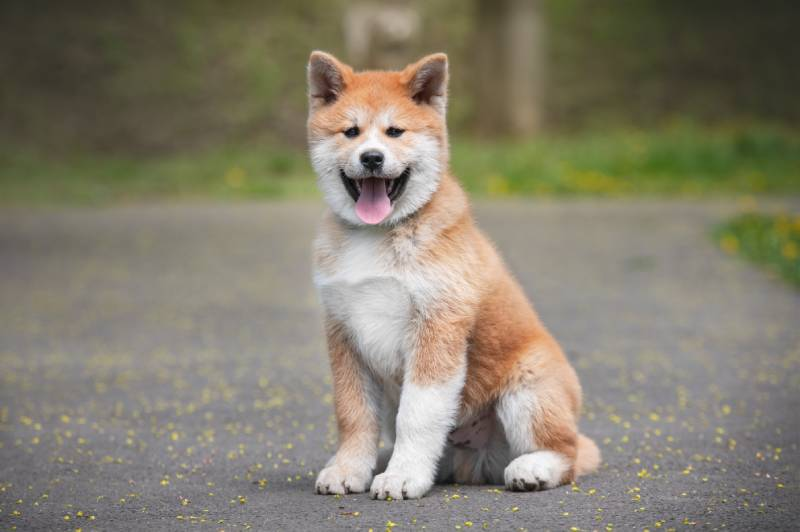

In [174]:
#An image of Akita Inu from the web
image_url = "https://www.dogster.com/wp-content/uploads/2024/03/Akita-Inu-puppy-outdoors_Kristina-Chizhmar_Shutterstock.jpg"
response = requests.get(image_url)
img_bytes = response.content
img = Image.open(BytesIO(img_bytes))
img.show()

In [175]:
import numpy as np

response = predictor.predict(
    img_bytes,
    initial_args={"ContentType": "image/jpeg"}
)

print(f"Result: {np.argmax(response[0]) + 1}")

Result: 4


In [185]:
predictor.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: pytorch-inference-2024-08-15-16-12-44-454
INFO:sagemaker:Deleting endpoint with name: pytorch-inference-2024-08-15-16-12-44-454
